In [1]:
%load_ext autoreload
%autoreload 2

## MolFeat


### Concept

Molfeat is organized in two main modules:

- `calc` which helps define a calculator function that transform a molecule into a vector of features
- `trans` which provides a transformer interface to work with an ensemble of molecule and handles compatibility with **scikit-learn**, **pytorch**, **dgl**, etc

### Setup

In [2]:
import datamol as dm
import random
import numpy as np
from loguru import logger

# set printing option
np.set_printoptions(threshold=10)

# set random list
np.random.seed(10)
random.seed(10)

data = dm.data.freesolv().sample(500).smiles.values
mol2d = data[83]

### Using the calc module


In [3]:
from molfeat.calc import RDKitDescriptors2D

calc = RDKitDescriptors2D()
calc(mol2d)

Using backend: pytorch


array([ 6.82415895, -1.37469136,  6.82415895, ...,  0.        ,
        0.        ,  3.        ])

### Using the trans module

Almost all transformers in `molfeat` are subclass of `MoleculeTransformer` which in turns implements `BaseFeaturizer` interface.  The base interface and transformer classes ensure some compatibility with the `scikit-learn` estimators as well as implementing commons features such as `__len__` and `collate_fn`. 



`MoleculeTransformer` accepts as input a callable that represents the featurizer which would be applied on each indiviual molecule. It can compute features under a parallelization mode and can handle datatype conversion. The class also offers too endpoints for featurizing a set of molecules ( `transform` and  `__call__`). The advantage of using `__call__` is the return of both the featurized vector and the ids where featurization was successful.


Note however that placing torch tensor to the GPU is not handled forcing users to appropriately optimize their code.

In [4]:
import torch
from molfeat.trans.fp import MoleculeTransformer

#### Checking the effect of parallelization

In [6]:
%%timeit
## Using the transformer with an input featurizer

trans = MoleculeTransformer(calc, n_jobs=4, verbose=True, dtype=torch.float)
X = trans(data, enforce_dtype=True)

1.36 s ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
## Using the transformer with an input featurizer

trans = MoleculeTransformer(calc, n_jobs=1, verbose=True, dtype=torch.float)
X = trans(data, enforce_dtype=True)

3.96 s ± 459 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# pretty printing of the transformer
trans = MoleculeTransformer(calc, n_jobs=1, verbose=True, dtype=torch.float)

print(trans)

MoleculeTransformer(dtype=torch.float32,
                    featurizer=<molfeat.calc.descriptors.RDKitDescriptors2D object at 0x7ff671945a50>)


#### Providing a custom featurizer

In [10]:
from rdkit.Chem.rdMolDescriptors import CalcNumHeteroatoms


def custom_featurizer(mol):
    """My custom featurizer"""
    mol = dm.to_mol(mol)
    return [mol.GetNumAtoms(), mol.GetNumBonds(), CalcNumHeteroatoms(mol), random.random()]

In [11]:
trans = MoleculeTransformer(custom_featurizer, n_jobs=0, verbose=True, dtype=float)
trans.transform(data[:10], ignore_errors=False)

[array([8.        , 7.        , 1.        , 0.17467059]),
 array([9.        , 9.        , 3.        , 0.30310511]),
 array([6.        , 5.        , 0.        , 0.36258741]),
 array([9.        , 8.        , 2.        , 0.45692842]),
 array([8.        , 8.        , 1.        , 0.86004914]),
 array([10.        , 11.        ,  1.        ,  0.23938029]),
 array([7.        , 7.        , 2.        , 0.43964778]),
 array([12.        , 12.        ,  8.        ,  0.37524299]),
 array([5.        , 4.        , 1.        , 0.58293156]),
 array([6.        , 5.        , 1.        , 0.23565393])]

#### Providing a name for a common featurizer

In [12]:
trans = MoleculeTransformer("ecfp", n_jobs=0, verbose=True, dtype=float, length=32)
trans(data[:10], ignore_errors=False, enforce_dtype=True)

array([[0., 1., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.]])

#### Fitting a transformer on a dataset to remove columns with nan values.

If you want to keep such columns or perform your own imputation, you should handle that at internal featurizer, or just not call `fit`

In [17]:
from molfeat.calc import MordredDescriptors

# 2D mordred descriptors
desc = MordredDescriptors(replace_nan=False, ignore_3D=True)
trans = MoleculeTransformer(desc, verbose=True, dtype=float, length=32)
# has nan
X = trans(data[:10], ignore_errors=False, enforce_dtype=True)
print(
    "Num Columns before fitting:",
    len(trans.columns),
    "\nNum of nan before fitting:",
    np.isnan(X).sum(),
    "\n-------",
)
# fitting
trans.fit(data)
X = trans(data[:10], ignore_errors=False, enforce_dtype=True)
print(
    "Num Columns after fitting:",
    len(trans.columns),
    "\nNum of nan after fitting:",
    np.isnan(X).sum(),
    "\n-------",
)

Num Columns before fitting: 1613 
Num of nan before fitting: 2774 
-------
Num Columns after fitting: 1066 
Num of nan after fitting: 0 
-------


### Training a scikit-learning pipeline to predict solubility

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [19]:
df = dm.data.freesolv()
X, y = df["smiles"], df["expt"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

feat = MoleculeTransformer("desc2d")
pipe = Pipeline([("feat", feat), ("scaler", StandardScaler()), ("rf", RandomForestRegressor())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('feat',
                 MoleculeTransformer(featurizer=<molfeat.calc.descriptors.RDKitDescriptors2D object at 0x7ff630220510>)),
                ('scaler', StandardScaler()), ('rf', RandomForestRegressor())])

In [20]:
pipe.score(X_test, y_test)

0.9020583487672389

/Users/manu/.miniconda/envs/molfeat/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='expt', ylabel='rf_pred'>

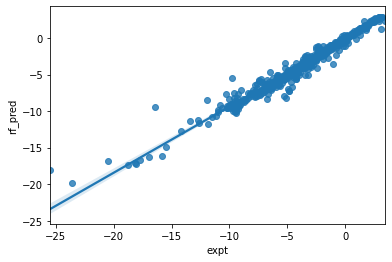

In [21]:
import seaborn as sns

ypred = pipe.predict(X)
df["rf_pred"] = ypred

sns.regplot("expt", "rf_pred", data=df)